In [1]:
import json
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
import pyproj # для конвертации координат в плоскость
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
# import descartes
from pylab import cm

# Создание сетки

shapely Polygon можно спутать с matplotlib patches:

https://gis.stackexchange.com/questions/197945/geopandas-polygon-to-matplotlib-patches-polygon-conversion

Переносим координаты в плоскость для построения чёткой сетки, затем конвертнем обратно вместе с сеткой:

http://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/

http://lyzidiamond.com/posts/4326-vs-3857

https://www.esri.com/arcgis-blog/products/arcgis-enterprise/mapping/measuring-distances-and-areas-when-your-map-uses-the-mercator-projection/


Ищем подходящую UTM зону для четкой проекции:

http://www.apsalin.com/utm-zone-finder.aspx

**Координаты Новосибирска:**
* Широта (latitude): 55.030199
* Долгота (longitude):82.920430

#### Параметры

In [1]:
# Директория с данными сетки
hex_data_dir = 'hexagon_data/'

# Наименование полигона Новосибирска
city_poly_filename = 'Весь Новосиб (с Пашино и ушами).geojson'

# Наименование GEOJSON файла с сеткой
hex_geojson_filename = 'novosib_coords_wgs84_setka1000_with_ears.json'

# Наименование CSV файла с расстояними между сотами
hc_distances_filename = 'hc_distances.csv'

# Радиус вписанной окружности
inner_circle_r = 1000.0

### Загрузка полигона Новосибирска

In [3]:
# Define some common projections using EPSG codes
# help for pyproj.Proj:
# http://pyproj4.github.io/pyproj/html/api/proj.html#pyproj-proj

## wgs84 -- 3D sphere model of Earth
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth

### for Novosib specially, appropriate UTM is needed
pm = pyproj.Proj("+init=EPSG:32644")

In [4]:
# Загрузка итогового полигона по Новосибирску:
with open(hex_data_dir + city_poly_filename) as f:
    novosib_new = json.load(f)
    
# Объединение полигонов и конвертация из объемных в плоские координаты: START
areas_to_union = []
for part in range(len(novosib_new['features'])):
    # load all parts of Novosibirsk
    novosib_part = novosib_new['features'][part]['geometry']['coordinates'][0]
    # Transform to 2d coords and make polygons
    # x for lon and y for lat
    novosib_part_coords = []
    for i in range(len(novosib_part)):
        ####### input in format (lon, lat) !!!!!!!!!!!!
        x, y = pyproj.transform(wgs84, pm, novosib_part[i][0], novosib_part[i][1])
        novosib_part_coords.append([x,y])
    novosib_part_polygon = Polygon(novosib_part_coords)
    areas_to_union.append(novosib_part_polygon)

# concatenate all parts of Novosib in one polygon
novosib_ears = cascaded_union(areas_to_union)

# Объединение полигонов и конвертация из объемных в плоские координаты: END

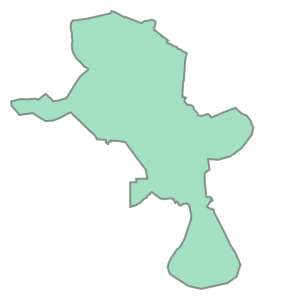

In [5]:
# Новосиб в плоских координатах:
novosib_ears

### Расчет гексагональнальной сетки

In [6]:
def calculate_polygons(startx, starty, endx, endy, radius):
    """ 
    Calculate a grid of hexagon coordinates of the given radius
    given lower-left and upper-right coordinates 
    Returns a list of lists containing 6 tuples of x, y point coordinates
    These can be used to construct valid regular hexagonal polygons
    
    You will probably want to use projected coordinates for this
    
    Возвращает GeoDataFrame, каждая строка -- полигон сетки (сота) 
    """
    # calculate side length given radius   
    sl = (2 * radius) * math.tan(math.pi / 6)
    # calculate radius for a given side-length
    # (a * (math.cos(math.pi / 6) / math.sin(math.pi / 6)) / 2)
    # see http://www.calculatorsoup.com/calculators/geometry-plane/polygon.php
    
    # calculate coordinates of the hexagon points
    # sin(30)
    p = sl * 0.5
    b = sl * math.cos(math.radians(30))
    w = b * 2
    h = 2 * sl
    
    # offset start and end coordinates by hex widths and heights to guarantee coverage     
    startx = startx - w
    starty = starty - h
    endx = endx + w
    endy = endy + h

    origx = startx
    origy = starty


    # offsets for moving along and up rows
    xoffset = b
    yoffset = 3 * p

    polygons = []
    row = 1
    counter = 0

    while starty < endy:
        if row % 2 == 0:
            startx = origx + xoffset
        else:
            startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty + p
            p2x = startx
            p2y = starty + (3 * p)
            p3x = startx + b
            p3y = starty + h
            p4x = startx + w
            p4y = starty + (3 * p)
            p5x = startx + w
            p5y = starty + p
            p6x = startx + b
            p6y = starty
            poly = [
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p5x, p5y),
                (p6x, p6y),
                (p1x, p1y)]
            polygons.append(poly)
            counter += 1
            startx += w
        starty += yoffset
        row += 1
    
    pols1 = [Polygon(polygons[i]) for i in range(len(polygons))]
    grid = gpd.GeoDataFrame({'geometry':pols1})

    return grid

In [7]:
# для размера сетки -- стороны прямоугольника
minx, miny, maxx, maxy = novosib_ears.bounds

**Радиус вписанной окружности сетки - 1 км**

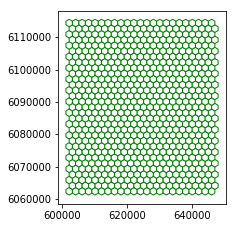

In [8]:
# radius = 1km
pols = calculate_polygons(minx, miny, maxx, maxy, inner_circle_r)
pols.plot(color='white', edgecolor='green', figsize=(3,4))

#### пробежимся циклом по сетке и получим пересечение полигона и сетки

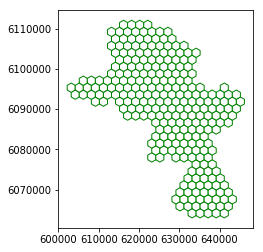

In [9]:
intersect_pol = [] # список сот, которые получились в результате пересечения
for i in range(len(pols)):
    # если пересечение границы города и сетки непустое, то включаем всю соту полностью
     if (novosib_ears.intersection(pols.iloc[i][0]).area > 0.0):
            intersect_pol.append(pols.iloc[i][0])
            
grid_intersect = gpd.GeoDataFrame({'geometry':intersect_pol})
grid_intersect.plot(color='white', edgecolor='green')

#### Число сот

In [11]:
len(grid_intersect[grid_intersect['geometry'].notnull()])

265

In [12]:
len(grid_intersect)

265

#### Сконвертируем плоские координаты полигонов сетки в 3D  

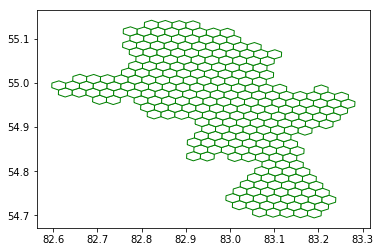

In [13]:
def tranform_to_3d(grid):
    """
    grid -- полигоны сетки в виде GeoDataFrame
    proj3d_pols -- список спроецированных в 3D полигонов сетки
    """
    ## x for lon and y for lat
    proj3d_pols = []
    for i in range(len(grid)):
        try:
            xp, yp = grid.iloc[i][0].exterior.coords.xy
            xp, yp = list(xp), list(yp)
            x, y = pyproj.transform(pm, wgs84, xp, yp)
            proj3d_pols.append(Polygon([(x[j],y[j]) for j in range(len(x))]))
        except AttributeError: 
            try:
                for k in range(len(grid.iloc[i][0])):
                    xp, yp = grid.iloc[i][0][k].exterior.coords.xy
                    xp, yp = list(xp), list(yp)
                    x, y = pyproj.transform(pm, wgs84, xp, yp)
                    proj3d_pols.append(Polygon([(x[j],y[j]) for j in range(len(x))]))
            except AttributeError:
                continue
    return proj3d_pols

grid_proj3d = gpd.GeoDataFrame({'geometry':tranform_to_3d(grid_intersect)})
grid_proj3d.plot(color='white', edgecolor='green')

### Итоговый geojson с сеткой

In [14]:
with open(hex_data_dir + hex_geojson_filename, 'w') as f:
    f.write(grid_proj3d.to_json())

# Таблица расстояний между сотами

In [15]:
grid_id = grid_intersect.copy()
grid_id['id'] = range(0, len(grid_id))

In [16]:
grid_id.loc[0, 'geometry'].area

3464101.6151374206

In [17]:
grid_id['geometry'][0].centroid.wkt

'POINT (633171.6531342913 6064130.961442689)'

In [18]:
grid_id['centre'] = grid_id['geometry'].centroid

In [19]:
grid_id.tail()

,geometry,id,centre
260,"POLYGON ((626171.6531342914 6108586.932170299,...",260,POINT (627171.6531342914 6109164.282439488)
261,"POLYGON ((615171.6531342914 6110318.982977868,...",261,POINT (616171.6531342914 6110896.333247057)
262,"POLYGON ((617171.6531342914 6110318.982977868,...",262,POINT (618171.6531342913 6110896.333247057)
263,"POLYGON ((619171.6531342914 6110318.982977868,...",263,POINT (620171.6531342914 6110896.333247057)
264,"POLYGON ((621171.6531342914 6110318.982977868,...",264,POINT (622171.6531342913 6110896.333247057)


In [20]:
cols = ['id_start', 'id_stop', 'distance']
distances = pd.DataFrame(columns = cols)

In [21]:
for id_hc_start in range(len(grid_id)):
    for id_hc_stop in range(len(grid_id)):
        dist = grid_id.loc[id_hc_start, 'centre'].distance(grid_id.loc[id_hc_stop, 'centre'])
        distances = distances.append({'id_start': int(id_hc_start), 'id_stop': int(id_hc_stop), 
                                     'distance': dist}, ignore_index=True)

### Итоговый csv файл со всеми расстояниями между всеми парами сот

**hc_distances.csv**

In [22]:
distances.to_csv(hex_data_dir + hc_distances_filename, encoding = 'utf-8-sig', index=False)